In [1]:
# !pip install igraph # for directed graph
# import igraph as ig

In [2]:
# !pip install networkx
import networkx as nx

In [3]:
import numpy as np
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import parse_input

In [4]:
from figure_2D import plot_undeployed_2D
from tools import get_center_position
import deploy_path as dp

In [5]:
def print_bumps_depressions(graph, bumps, depressions):
    print('\n--> bumps:')
    print(*[(b, graph.nodes[b]['height']) for b in bumps], sep='\n')
    print('\n--> depression:')
    print(*[(d, graph.nodes[d]['height']) for d in depressions], sep='\n')

### **Mesh Path**

In [6]:
from mesh_paths import  saddle_path,  igloo_coars_path, \
                        squid_path,   igloo_path,       \
                        peanut_path,  lilium_path,      \
                        hive_path,    trililium_path

In [7]:
mesh_path = saddle_path

---

In [8]:
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(mesh_path, handleBoundary = False, isHex = False, use_target_surface = False)

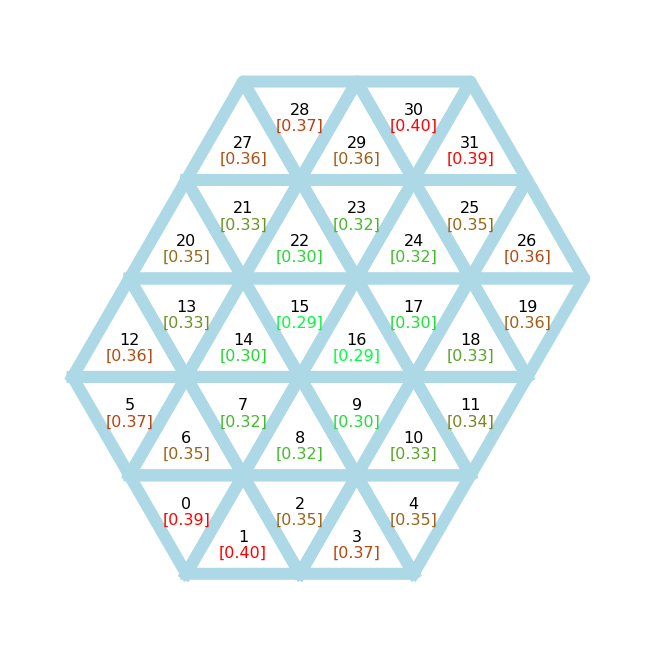

In [9]:
plot_undeployed_2D(input_data,
                   curr_um,
                   show_height=True,
                   show_plot=True)

In [10]:
connectivity = np.array(input_data['umbrella_connectivity'])
pos = get_center_position(curr_um)[:,:2]

In [11]:
graph = dp.create_graph(connectivity, curr_um)

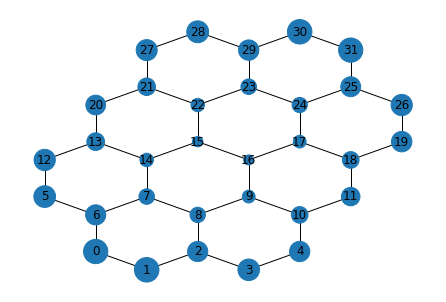

In [12]:
dp.draw_height(graph, pos, with_labels=True)

In [13]:
bumps, depressions = dp.find_extrems(graph, drop_boudary=False)

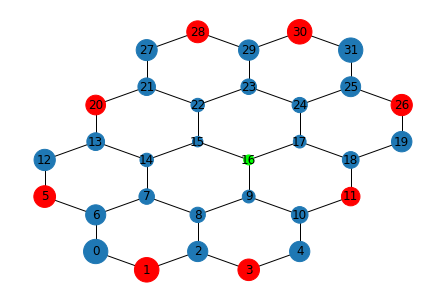


--> bumps:
(1, 0.3958087118693808)
(3, 0.36612678895446993)
(5, 0.3676488070592524)
(11, 0.3398361053379975)
(20, 0.3494303464105304)
(26, 0.36327845218711474)
(28, 0.3691835224160484)
(30, 0.3957839736796042)

--> depression:
(16, 0.2869929172081087)


In [14]:
# draw extrem points (bumps are red and depression are green)
dp.draw_height_extrems(graph, pos, bumps, depressions, with_labels=True)
print_bumps_depressions(graph, bumps, depressions)

In [15]:
paths = dp.shortes_paths(graph, bumps, depressions); paths

[[1, 2, 8, 9, 16],
 [3, 4, 10, 9, 16],
 [5, 12, 13, 14, 15, 16],
 [11, 18, 17, 16],
 [20, 13, 14, 15, 16],
 [26, 19, 18, 17, 16],
 [28, 27, 21, 22, 15, 16],
 [30, 31, 25, 24, 17, 16]]

In [16]:
# light_grey = 211/255
# colors_default = [(light_grey,light_grey,light_grey)] * len(graph) # light_grey

In [17]:
# raise NotImplementedError('stop `run all` here to select some depressions in next cell')

In [18]:
kept_depressions = depressions

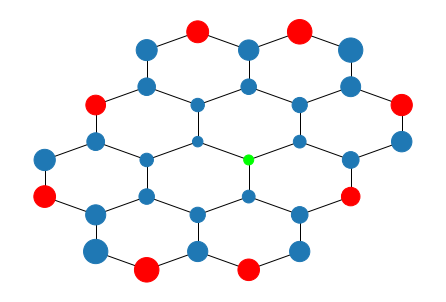

In [19]:
# draw extrem points (bumps are red and depression are green)
dp.draw_height_extrems(graph, pos, bumps, kept_depressions)

In [20]:
paths = dp.shortes_paths(graph, bumps, kept_depressions); paths

[[1, 2, 8, 9, 16],
 [3, 4, 10, 9, 16],
 [5, 12, 13, 14, 15, 16],
 [11, 18, 17, 16],
 [20, 13, 14, 15, 16],
 [26, 19, 18, 17, 16],
 [28, 27, 21, 22, 15, 16],
 [30, 31, 25, 24, 17, 16]]

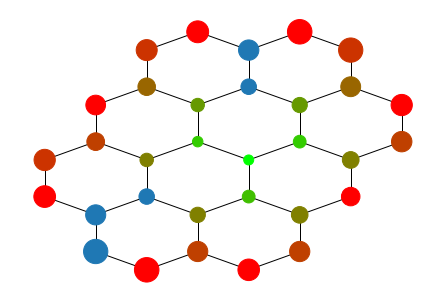

In [21]:
dp.draw_height_path(graph, pos, paths)

In [22]:
dp.draw_height_surrounds(graph, pos, dp.surround_bumps(graph, bumps), with_labels=True)

IndexError: list index out of range

---
### Sortest Path Approach

In [ ]:
def surrounding(graph, bump, level=1, verbose=False):
    def surround(graph, prev_surr):
        'broken if drop_boundary=False'
        graph_copy = graph.copy()

        neighbors = []
        for pn in prev_surr:
            neighbors.extend([n for n in graph_copy.neighbors(pn) if n not in prev_surr])
            graph_copy.remove_node(pn)

        nb_neigh = len(neighbors)
        if nb_neigh==1 : return neighbors

        paths = []
        # not optimal, but necessary as we lose proximity information by keeping only unique units with numpy
        for i, source in enumerate(neighbors):
            for target in neighbors[i+1:]:
                try:
                    paths.extend(nx.shortest_path(graph_copy, source=source, target=target, weight=None))
                except nx.NetworkXNoPath: continue

        surroundings = list(np.unique(paths))

        return graph_copy, surroundings

    
    gr, sur = surround(graph, [bump])
    if verbose: dp.draw_height_extrems(graph, pos, [bump], sur, with_labels=True)
    for _ in range(level-1):
        gr, sur = surround(gr, sur)
        if sur==[]: break
        if verbose: dp.draw_height_extrems(graph, pos, [bump], sur, with_labels=True)
    return gr, sur

In [ ]:
surrs = {}
for bump in bumps:
    _, surr = surrounding(graph, bump, level=2,verbose=True)
    surrs[bump] = surr

In [ ]:
# def surrounding_bumps(init_graph, bumps, level=1, verbose=False):
#     ''' broken if hole in network...'''
#     def surround(graph, prev_surr):
#         'broken if drop_boundary=False'
#         graph_copy = graph.copy()

#         neighbors = []
#         for pn in prev_surr:
#             # if pn in level_surr and pn not in bumps: continue
#             neighbors.extend([n for n in graph_copy.neighbors(pn) if n not in prev_surr])
#             graph_copy.remove_node(pn)
            
#         nb_neigh = len(neighbors)
#         if nb_neigh==1 : return neighbors

#         paths = []
#         # not optimal, but necessary as we lose proximity information by keeping only unique units with numpy
#         for i, source in enumerate(neighbors):
#             for target in neighbors[i+1:]:
#                 try:
#                     paths.extend(nx.shortest_path(graph_copy, source=source, target=target, weight=None))
#                 except nx.NetworkXNoPath: continue

#         surroundings = list(np.unique(paths))
#         if (verbose): dp.draw_height(graph_copy, pos)
#         if (verbose): dp.draw_height_extrems(init_graph, pos, bumps, surroundings, with_labels=True)
#         return surroundings


#     graph_shared = init_graph.copy()
    
#     prev_surr_dic = {}
#     for b in bumps:
#         prev_surr_dic[b] = [graph_shared.copy(),[b]]

#     for _ in range(level):
#         prev_surr_level = []
#         for key, value in prev_surr_dic.items():
#             prev_surr_level.extend(value[1])
#             prev_surr_dic[key][1] = surround(*value)
        
#         surr_level = []
#         for key, (_, neigh) in prev_surr_dic.items():
#             existing_surr = [v for v in neigh if v not in prev_surr_level]
#             surr_level.extend(existing_surr)
#             prev_surr_dic[key][1] = existing_surr
        
#         graph_shared.remove_nodes_from(prev_surr_level) # if node not in graph, silently ignored
#         for key, (_, neigh) in prev_surr_dic.items():
#             prev_surr_dic[key] = [graph_shared.copy(), neigh]
        
#         if (surr_level == []):
#             break
            
#         if (verbose): dp.draw_height_extrems(init_graph, pos, bumps, surr_level, with_labels=True)
        
#     return graph_shared, surr_level

In [ ]:
# def surrounding_bumps(init_graph, bumps, level=1, verbose=False):
#     ''' broken if hole in network...'''
#     def surround(graph, prev_surr):
#         'broken if drop_boundary=False'
#         graph_copy = graph.copy()

#         neighbors = []
#         for pn in prev_surr:
#             # if pn in level_surr and pn not in bumps: continue
#             neighbors.extend([n for n in graph_copy.neighbors(pn) if n not in prev_surr])
#             graph_copy.remove_node(pn)
            
#         nb_neigh = len(neighbors)
#         if nb_neigh==1 : return neighbors

#         paths = []
#         # not optimal, but necessary as we lose proximity information by keeping only unique units with numpy
#         for i, source in enumerate(neighbors):
#             for target in neighbors[i+1:]:
#                 try:
#                     paths.extend(nx.shortest_path(graph_copy, source=source, target=target, weight=None))
#                 except nx.NetworkXNoPath: continue

#         surroundings = list(np.unique(paths))
#         # if (verbose): dp.draw_height(graph_copy, pos)
#         # if (verbose): dp.draw_height_extrems(init_graph, pos, bumps, surroundings, with_labels=True)
#         return graph_copy, surroundings


#     graph_shared = init_graph.copy()
    
#     prev_surr_dic = {}
#     for b in bumps:
#         prev_surr_dic[b] = [graph_shared.copy(),[b]]

#     for _ in range(level):
#         prev_surr_level = []
#         prev_surr_level_flat = []
#         for key, value in prev_surr_dic.items():
#             prev_surr_level.append(value[1])
#             prev_surr_level_flat.extend(value[1])
#             prev_surr_dic[key] = [*surround(*value)]
        
#         surr_level = []
#         for (key, (gr, neigh)), ps in zip(prev_surr_dic.items(), prev_surr_level):
#             existing_surr = [v for v in neigh if v not in prev_surr_level_flat]
#             surr_level.extend(existing_surr)
#             gr.remove_nodes_from(ps)
#             graph_shared.remove_nodes_from(ps)
#             prev_surr_dic[key][1] = existing_surr
            
#         print
#         dp.draw_height(graph_shared, pos)
        
#         # graph_shared.remove_nodes_from(prev_surr_level) # if node not in graph, silently ignored
#         # for key, (_, neigh) in prev_surr_dic.items():
#         #     prev_surr_dic[key] = [graph_shared.copy(), neigh]
        
#         if (surr_level == []):
#             break
            
#         if (verbose): dp.draw_height_extrems(init_graph, pos, bumps, surr_level, with_labels=True)
        
#     return graph_shared, surr_level

In [ ]:
# surrounding_bumps(graph, bumps, level=7, verbose=True);

---
### Neighbors Approach

In [23]:
def surround_neigh(graph, curr_surr, prev_surr):
    
    if len(curr_surr) == 1:
        center = curr_surr[0]
        
        # 1st degre neighbors (direct link to center)
        neighbors_1 = [n1 for n1 in graph.neighbors(center)]
        
        # 2nd degre neighbors
        neighbors_2 = []
        for n1 in neighbors_1:
            neighbors_2.extend([n2 for n2 in graph.neighbors(n1) if n2 != center])
        
        # 3rd degre neighbors
        neighbors_3 = []
        for n2 in neighbors_2:
            for nn2 in graph.neighbors(n2):
                if nn2 in neighbors_1: continue
                if nn2 in neighbors_3: continue
                for nnn2 in graph.neighbors(nn2):
                    if nnn2 == n2: continue
                    if nnn2 in neighbors_2: neighbors_3.append(nn2)

        surroundings = neighbors_1 + neighbors_2 + neighbors_3
        
        return surroundings, curr_surr
    
    neighbors = []
    for cs in curr_surr:
        neighbors.extend([n for n in graph.neighbors(cs) if n not in curr_surr and n not in prev_surr])

    surroundings = []
    for n in neighbors:
        surroundings.append(n)
        surroundings.extend([nn for nn in graph.neighbors(n) if nn not in curr_surr and nn not in surroundings])

    return surroundings, curr_surr


def surround_neigh_level(graph, bump, level=1, verbose=False):
    
    surr = [bump]
    prev_surr = []
    for l in range(level):
        surr, prev_surr = surround_neigh(graph, surr, prev_surr)
        if surr == [] : break
        if (verbose): dp.draw_height_extrems(graph, pos, [bump], surr, with_labels=True)
        
    return surr

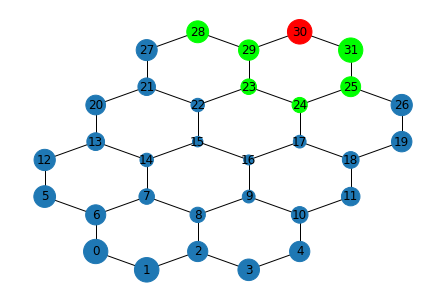

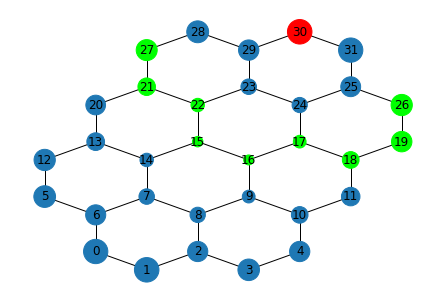

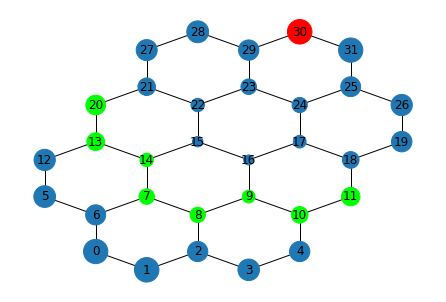

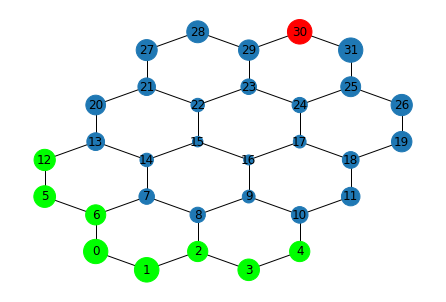

In [24]:
surr = surround_neigh_level(graph, bumps[-1], level=10, verbose=True)

In [25]:
def surround_neigh_bumps(graph, bumps, level=1, verbose=False):
    def surround_neigh(graph, curr_surr, prev_surr, cum_surr):
        # first level is quite different
        if len(curr_surr) == 1:
            center = curr_surr[0]

            # 1st degre neighbors (direct link to center)
            neighbors_1 = [n1 for n1 in graph.neighbors(center)]

            # 2nd degre neighbors
            neighbors_2 = []
            for n1 in neighbors_1:
                neighbors_2.extend([n2 for n2 in graph.neighbors(n1) if n2 != center])

            # 3rd degre neighbors
            neighbors_3 = []
            for n2 in neighbors_2:
                for nn2 in graph.neighbors(n2):
                    if nn2 in neighbors_1: continue
                    if nn2 in neighbors_3: continue
                    for nnn2 in graph.neighbors(nn2):
                        if nnn2 == n2: continue
                        if nnn2 in neighbors_2: neighbors_3.append(nn2)

            next_surr = neighbors_1 + neighbors_2 + neighbors_3
            return next_surr, curr_surr
        
        # Level greater than 1
        neighbors = []
        for cs in curr_surr:
            neighbors.extend([n for n in graph.neighbors(cs) if n not in curr_surr and n not in prev_surr])

        next_surr = []
        for n in neighbors:
            next_surr.append(n)
            next_surr.extend([nn for nn in graph.neighbors(n) if nn not in curr_surr
                                                              and nn not in next_surr
                                                              and nn not in cum_surr])
        return next_surr, curr_surr
    
    dic = {}
    for b in bumps:
        dic[b] = [b], []
    shared_graph = graph.copy()
    
    cum_surr = [] # cumulative
    for l in range(level):
        surr_level = []
        for key,(curr, prev) in dic.items():
            c, p = surround_neigh(shared_graph, curr, prev, cum_surr)
            surr = [c0 for c0 in c if c0 not in cum_surr]
            cum_surr.extend(surr)
            surr_level.extend(surr)
            dic[key] = surr, p
            
        if surr_level==[] : break # no more medium to propagate the wave
        if (verbose):
            dp.draw_height_extrems(graph, pos, bumps, surr_level, with_labels=True)
            
    return surr_level

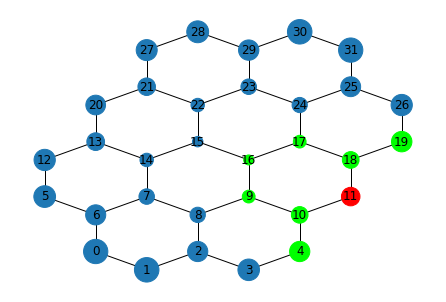

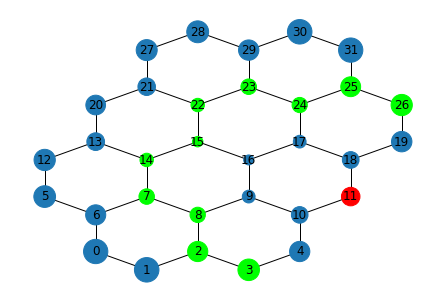

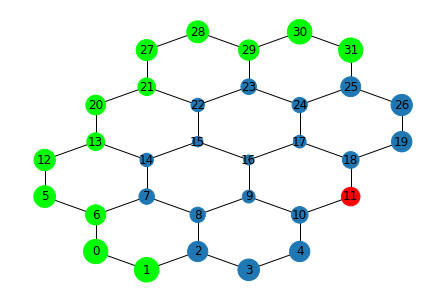

[]

In [28]:
surround_neigh_bumps(graph, [bumps[3]], level=4, verbose=True)